In [1]:
import pandas as pd
from collections import Counter
import numpy as np
import math
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
%matplotlib inline
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/justinchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
dataset = pd.read_csv('/Users/justinchen/Documents/mental_health_subreddits_dataset.csv')

In [3]:
sample = dataset.sample(20000)
sample.head()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
24276,11553989,anxiety,1603362345,99.8% who get Covid are perfectly fine. Don't ...,0.2263
3844,2543582,anxiety,1629501617,I hate to tell you this but is the second dose...,-0.8402
29165,13111016,anxiety,1598490352,Moderna Says Covid-19 Vaccine Shows Signs of W...,0.0000
13613,7525354,covid19_support,1614568211,"Personally, I would get people to back off on ...",0.3022
15319,8226002,suicidewatch,1612350126,"I even forgot some things, like getting covid ...",0.3612


In [4]:
count = Counter()
for index, row in sample.iterrows():
    if row['subreddit.name'] == 'anxiety':
        count['anxiety'] += 1
    if row['subreddit.name'] == 'depression':
        count['depression'] += 1
    if row['subreddit.name'] == 'suicidewatch':
        count['SuicideWatch'] += 1
    if row['subreddit.name'] == 'mentalhealth':
        count['mentalhealth'] += 1
    if row['subreddit.name'] == 'covid19_support':
        count['COVID19_support'] += 1
count

Counter({'anxiety': 7328,
         'COVID19_support': 6949,
         'SuicideWatch': 1745,
         'mentalhealth': 1413,
         'depression': 2565})

## Preprocessing

In [5]:
import re #regex library used for substituting words

In [6]:
#removing stopwords and urls, stemming, making lowercase 
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def cleaning(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [7]:
def post_cleaning(text):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ',text)

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 
    
    #remove digits
    processed_feature = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", processed_feature)

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    return processed_feature

In [8]:
#above functions combined
def preprocessing(text):
    line = cleaning(text)
    line = post_cleaning (line)
    return line

In [9]:
sample.body = sample.body.apply(lambda x: preprocessing(x))

In [10]:
sample.head()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
24276,11553989,anxiety,1603362345,8 get covid perfectly fine let media scare we...,0.2263
3844,2543582,anxiety,1629501617,hate tell second dose makes people sick maybe ...,-0.8402
29165,13111016,anxiety,1598490352,moderna says covid vaccine shows signs working...,0.0000
13613,7525354,covid19_support,1614568211,personally would get people back april fools p...,0.3022
15319,8226002,suicidewatch,1612350126,even forgot things like getting covid grandfat...,0.3612


In [11]:
for sentiment in sample['sentiment']:
    if sentiment > 0:
        sample['sentiment'].replace({sentiment : 'positive'}, inplace=True)
    if sentiment < 0:
        sample['sentiment'].replace({sentiment : 'negative'}, inplace=True)
    else:
        sample['sentiment'].replace({sentiment : 'neutral'}, inplace=True)

Text(0.5, 1.0, 'Sentiment Data Distribution')

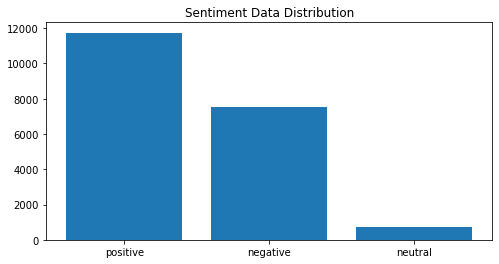

In [12]:
#Graphing
val_count = sample.sentiment.value_counts()
plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [13]:
sample.head()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
43069,16933287,covid19_support,1586118631,little brother sick christmas week covid sympt...,negative
34885,14698214,depression,1593887677,yeah really bad covid social distancing enable...,negative
24591,11652122,suicidewatch,1603057097,dude death answer tried kill work understood w...,positive
24051,11480801,covid19_support,1603590027,hey thanks replies input greatly appreciated y...,positive
40029,16087761,anxiety,1588880060,big emily oster fan economist specializes pare...,positive


In [13]:
from sklearn.model_selection import train_test_split

In [14]:
 # Splits Dataset into Training and Testing set
train_size = 0.8
train_data, test_data = train_test_split(sample, test_size=1-train_size, random_state=42, shuffle=True)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 16000
Test Data size 4000


## Vectorizing

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [46]:
vectorizer = TfidfVectorizer(max_features=10000,
                             min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
vectorizer.fit(train_data.body.to_list())
x_train = vectorizer.transform(train_data.body.to_list())
x_test = vectorizer.transform(test_data.body.to_list())

In [47]:
print("x_train Shape:",x_train.shape)
print("x_test Shape:",x_test.shape)

x_train Shape: (16000, 8943)
x_test Shape: (4000, 8943)


In [18]:
from sklearn.preprocessing import LabelEncoder

In [28]:
encoder = LabelEncoder() #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (16000, 1)
y_test shape: (4000, 1)


## Random Forest Model

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [51]:
model = RandomForestClassifier()
model.fit(x_train, y_train.ravel())
predicted_labels = model.predict(x_test)
print ('Accuracy:', model.score(x_test, y_test))
print (model.decision_path)

Accuracy: 0.7605
<bound method BaseForest.decision_path of RandomForestClassifier()>
